# Цель работы
Изучить постановку задачи многокритериальной оптимизации (МКО); овладеть навыками решения задач МКО с помощью различных методов, выполнить сравнительный анализ результатов, полученных с помощью разных методов.

# Постановка задачи
Выбрать лучшую из альтернатив решения предложенной задачи по
варианту с точки зрения указанных критериев следующими
методами:
1. замена критериев ограничениями,
2. формирование и сужение множества Парето,
3. взвешивание и объединение критериев,
4. анализ иерархий.

Необходимо выбрать породу дерева для строительства:
1. береза,
2. сосна,
3. дуб,
4. лиственница.

По критериям:

| Признак               | Характеристика |
|-----------------------|----------------|
| Долговечность         | лиственница > дуб >> сосна > береза. |
| Цена за $1м^3$        | дуб > лиственница > сосна > береза.|
| Водостойкость         | лиственница > сосна >> дуб > береза. |
| Легкость обработки    | береза >> сосна > дуб > лиственнница.|

# Практическая часть

## Подготовительная часть

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [2]:
criteria = np.array(['durability', 'price', 'water resistance', 'ease of processing'])
alternatives = np.array(['birch', 'pine', 'oak', 'larch'])

## Метод замены критериев ограничениями

### Вектор весов критериев

In [3]:
weights = np.array([10, 8, 6, 4])
weights = weights / np.sum(weights)

pd.DataFrame(data=[weights], index=['weight'], columns=criteria).round(2)

durability  price  water resistance  ease of processing
weight        0.36   0.29              0.21                0.14

### Матрица оценки альтернатив

In [4]:
A = np.array([[2, 4, 8, 10], [8, 6, 2, 4], [2, 8, 4, 10], [10, 6, 4, 2]], dtype=float).transpose()
pd.DataFrame(data=A, index=alternatives, columns=criteria)

durability  price  water resistance  ease of processing
birch         2.0    8.0               2.0                10.0
pine          4.0    6.0               8.0                 6.0
oak           8.0    2.0               4.0                 4.0
larch        10.0    4.0              10.0                 2.0

### Главный критерий

In [5]:
major_criterion = 'durability'

# put the major criterion at the beginning for convenience
major_criterion_index = criteria.tolist().index(major_criterion)
A[:, [major_criterion_index, 0]] = A[:, [0, major_criterion_index]]
criteria[[major_criterion_index, 0]] = criteria[[0, major_criterion_index]]
pd.DataFrame(data=A, index=alternatives, columns=criteria)

durability  price  water resistance  ease of processing
birch         2.0    8.0               2.0                10.0
pine          4.0    6.0               8.0                 6.0
oak           8.0    2.0               4.0                 4.0
larch        10.0    4.0              10.0                 2.0

### Минимально допустимые уровни остальных критериев

In [6]:
acceptances = {criteria[1]: 0.5, criteria[2]: 0.33, criteria[3]: 0.25}
for i, key in enumerate(acceptances):
  print(f'{key}: {acceptances[key]} * max{{A_{i + 2}}}')

price: 0.5 * max{A_2}
water resistance: 0.33 * max{A_3}
ease of processing: 0.25 * max{A_4}


### Нормирование матрицы $A$

$$ A_{ij} = \frac{A_{ij} - min\{A_j\}}{max\{A_j\} - min\{A_j\}} $$

In [7]:
A_normalized = np.copy(A)
for i in range(1, A.shape[1]):
  col = A_normalized[:, i]
  max, min = col.max(), col.min()
  A_normalized[:, i] = (col - min) / (max - min)
pd.DataFrame(data=A_normalized, index=alternatives, columns=criteria).round(2)

durability  price  water resistance  ease of processing
birch         2.0   1.00              0.00                1.00
pine          4.0   0.67              0.75                0.50
oak           8.0   0.00              0.25                0.25
larch        10.0   0.33              1.00                0.00

### Приемлемое решение

При заданных условиях приемлемой является только **сосна**:

In [8]:
df = pd.DataFrame(data=A_normalized, index=alternatives, columns=criteria)
df.iloc[:, 1:] >= acceptances.values()

price  water resistance  ease of processing
birch   True             False                True
pine    True              True                True
oak    False             False                True
larch  False              True               False

## Метод формирования и сужения множества Парето

Выберем в качестве главных критериев для данного метода **долговечность** и **цену** (оси x и по оси y соответственно). Сформируем множество Парето графическим методом.

In [9]:
major_criteria = ['durability', 'price']

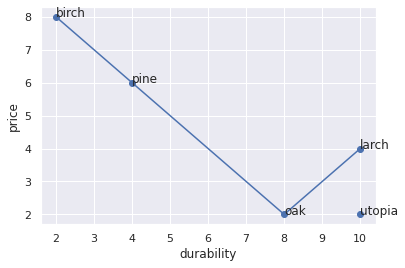

In [10]:
df = pd.DataFrame(data=A, index=alternatives, columns=criteria)
df_major_criteria = df.loc[:, major_criteria]

utopia = np.array([10, 2])
x = np.append(df_major_criteria.values[:, 0], utopia[0])
y = np.append(df_major_criteria.values[:, 1], utopia[1])

plt.scatter(x, y)
plt.xlabel(major_criteria[0])
plt.ylabel(major_criteria[1])
plt.plot(major_criteria[0], major_criteria[1], data=df)

annotation = df_major_criteria.index.append(pd.Index(['utopia']))
for i, label in enumerate(annotation):
    plt.annotate(label, (x[i], y[i]))

In [11]:
def euclidean_distance(a, b):
  return np.linalg.norm(a - b)

def is_zero(x):
  return abs(x) < 1e-6

indices = []
min_distance = np.inf
for i, point in enumerate(df_major_criteria.values):
    distance = euclidean_distance(point, utopia)
    if distance < min_distance:
        indices = [i]
        min_distance = distance
    elif is_zero(distance - min_distance):
      indices.append(i)

for index in indices:
  print(f'[{annotation[index]}] is an optimal alternative')
print(f'The minimum distance is [{min_distance}]')

[oak] is an optimal alternative
[larch] is an optimal alternative
The minimum distance is [2.0]


## Метод взвешивания и объединения критериев

### Нормализованная матрица

In [12]:
df = pd.DataFrame(data=A, index=alternatives, columns=criteria)
df_normalized = (df / df.sum())
df_normalized.round(2)

durability  price  water resistance  ease of processing
birch        0.08    0.4              0.08                0.45
pine         0.17    0.3              0.33                0.27
oak          0.33    0.1              0.17                0.18
larch        0.42    0.2              0.42                0.09

### Экспертная оценка

Составим экспертную оценку критериев по методу попарного сравнения:
$$ f_{i} > f_{j} \Leftrightarrow \text{цель i важнее цели j}$$
$$ \gamma_{ij} = 
\begin{cases}
1, & \quad f_{i} > f_{j} \\
0, & \quad f_{i} < f_{j} \\ 
0.5, & \quad f_{i} \approx f{j} \\
\end{cases}
$$

*да, символы и термины вводятся без определения...*

In [13]:
evaluation = np.triu(np.logical_not(np.eye(4, 4)).astype(float))
evaluation[0, 1] = evaluation[1, 0] = 0.5
pd.DataFrame(data=evaluation, index=criteria, columns=criteria)

durability  price  water resistance  ease of processing
durability                 0.0    0.5               1.0                 1.0
price                      0.5    0.0               1.0                 1.0
water resistance           0.0    0.0               0.0                 1.0
ease of processing         0.0    0.0               0.0                 0.0

Получим вектор весов критериев:

In [14]:
alpha = evaluation.sum(axis=1)
alpha_normalized = alpha / alpha.sum()
pd.DataFrame(
  data=[alpha, alpha_normalized],
  index=['alpha', 'alpha normalized'],
  columns=criteria).round(2)

durability  price  water resistance  ease of processing
alpha                   2.50   2.50              1.00                 0.0
alpha normalized        0.42   0.42              0.17                 0.0

Умножим нормализованную матрицу на нормализованный вектор весов
критериев и получим значения объединенного критерия для всех
альтернатив:

In [15]:
integral_evaluation = df_normalized.values @ alpha_normalized
print(integral_evaluation.round(2))
print(f'Optimal alternative is [{alternatives[np.argmax(integral_evaluation)]}]')

[0.22 0.25 0.21 0.33]
Optimal alternative is [larch]


Как видно из полученной интегральной оценки, наиболее приемлемой
является **лиственница**

## Метод анализа иерархий

Попарное сравнение критериев по важности по девятибалльной шкале с составлением соответствующей матрицы (таблицы) размера ($n \times n$). Система парных сведений приводит к результату, который может быть представлен в виде обратно симметричной матрицы. Элементом матрицы $(a_{ij})$ является интенсивность проявления элемента иерархии $i$ относительно элемента иерархии $j$, оцениваемая по шкале интенсивности от 1 до 9, где оценки имеют следующий смысл:

- равная важность – 1,
- умеренное превосходство – 3,
- значительное превосходство – 5,
- сильное превосходство – 7,
- очень сильное превосходство – 9,
- в промежуточных случаях ставятся четные оценки: 2, 4, 6, 8.

Индекс согласованности локальных приоритетов вычисляется по формуле:

$$ ИС = \dfrac{\lambda_{max} - n}{n - 1}, $$

где $n$ – размерность матрицы, а $\lambda_{max}$ вычисляется следующим образом:  
- суммируется каждый столбец матрицы парных сравнений; 
- сумма  первого  столбца  умножается  на  первую компоненту локального вектора приоритетов, сумма второго столбца на вторую компоненту  и т. д.;  
- полученные произведения суммируются. 

Отношение согласованности находим по формуле:

$$ ОС = \dfrac{ИС}{СС}, $$

где значение $СС$ (случайная согласованность) зависит только от размерности матрицы парных сравнений. И определяется по таблице:

| Размерность таблицы | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|-|-|-|-|-|-|-|-|-|-|-|
| Случайная согласованность | 0 | 0 | 0,58 | 0,9 | 1,12 | 1,24 | 1,32 | 1,41 | 1,45 | 1,49 |

В нашем случае $СС$ равно $0,9$

Если  для  конкретной  матрицы  окажется,  что  $ОС  >  0,1$,  то  можно  утверждать,  что суждения  эксперта,  на  основе  которых  заполнена  исследуемая  матрица,  сильно рассогласованы, и ему надлежит заполнить матрицу заново, более внимательно используя при этом шкалу парных сравнений. 

Для каждого из критериев составим и нормализуем матрицу попарного сравнения альтернатив.

In [16]:
N = 4
consistency = 0.9

def sum_and_normalize(value, idx=alternatives):
    df = pd.DataFrame(data=value, index=idx, columns=idx)
    df['sum'] = df.sum(axis=1)
    df['sum_normalized'] = df['sum'] / df['sum'].sum()
    return df

def get_consistency_relation(df):
    col_sum = df.sum()
    lambda_max = (col_sum * df['sum_normalized']).sum()
    return (lambda_max - N) / ((N - 1) * consistency)

### Долговечность

In [17]:
durability_matrix = [
                      [1, 1/2, 1/4, 1/8],
                      [2, 1, 1/3, 1/7],
                      [4, 3, 1, 1/3],
                      [8, 7, 3, 1]
                    ]

durability_df = sum_and_normalize(durability_matrix)
durability_df.round(2)

birch  pine   oak  larch    sum  sum_normalized
birch      1   0.5  0.25   0.12   1.88            0.06
pine       2   1.0  0.33   0.14   3.48            0.11
oak        4   3.0  1.00   0.33   8.33            0.25
larch      8   7.0  3.00   1.00  19.00            0.58

In [18]:
durability_cr = get_consistency_relation(durability_df).round(2)
print(f'[durability] consistency relation is [{durability_cr}]')

[durability] consistency relation is [0.07]


### Цена

In [19]:
price_matrix = [
                  [1, 1/2, 1/7, 1/5],
                  [2, 1, 1/5, 1/3],
                  [7, 5, 1, 3],
                  [5, 3, 1/3, 1]
                ]

price_df = sum_and_normalize(price_matrix)
price_df.round(2)

birch  pine   oak  larch    sum  sum_normalized
birch      1   0.5  0.14   0.20   1.84            0.06
pine       2   1.0  0.20   0.33   3.53            0.12
oak        7   5.0  1.00   3.00  16.00            0.52
larch      5   3.0  0.33   1.00   9.33            0.30

In [20]:
price_cr = get_consistency_relation(price_df).round(2)
print(f'[price] consistency relation is [{price_cr}]')

[price] consistency relation is [0.09]


### Водостойкость

In [21]:
water_resistance_matrix = [
                            [1, 1/6, 1/2, 1/9],
                            [6, 1, 3, 1/3],
                            [2, 1/3, 1, 1/7],
                            [9, 3, 7, 1]
                          ]

water_resistance_df = sum_and_normalize(water_resistance_matrix)
water_resistance_df.round(2)

birch  pine  oak  larch    sum  sum_normalized
birch      1  0.17  0.5   0.11   1.78            0.05
pine       6  1.00  3.0   0.33  10.33            0.29
oak        2  0.33  1.0   0.14   3.48            0.10
larch      9  3.00  7.0   1.00  20.00            0.56

In [22]:
water_resistance_cr = get_consistency_relation(water_resistance_df).round(2)
print(f'[water_resistance] consistency relation is [{water_resistance_cr}]')

[water_resistance] consistency relation is [0.08]


### Легкость обработки

In [23]:
eop_matrix = [
                [1, 4, 6, 8],
                [1/4, 1, 2, 4],
                [1/6, 1/2, 1, 2],
                [1/8, 1/4, 1/2, 1]
              ]

eop_df = sum_and_normalize(eop_matrix)
eop_df.round(2)

birch  pine  oak  larch    sum  sum_normalized
birch   1.00  4.00  6.0      8  19.00            0.60
pine    0.25  1.00  2.0      4   7.25            0.23
oak     0.17  0.50  1.0      2   3.67            0.12
larch   0.12  0.25  0.5      1   1.88            0.06

In [24]:
eop_cr = get_consistency_relation(eop_df).round(2)
print(f'[ease of process] consistency relation is [{eop_cr}]')

[ease of process] consistency relation is [0.08]


Проведем оценку приоритетов критериев:

In [25]:
priority_matrix = [
                  [1, 2, 4, 7],
                  [1/2, 1, 2, 5],
                  [1/4, 1/2, 1, 3],
                  [1/7, 1/5, 1/3, 1]
                ]
priority_df = sum_and_normalize(priority_matrix, criteria)
priority_df.round(2)

durability  price  water resistance  ease of processing  \
durability                1.00    2.0              4.00                   7   
price                     0.50    1.0              2.00                   5   
water resistance          0.25    0.5              1.00                   3   
ease of processing        0.14    0.2              0.33                   1   

                      sum  sum_normalized  
durability          14.00            0.48  
price                8.50            0.29  
water resistance     4.75            0.16  
ease of processing   1.68            0.06

In [26]:
priority_cr = get_consistency_relation(priority_df).round(2)
print(f'[priority] consistency relation is [{priority_cr}]')

[priority] consistency relation is [0.05]


Составим матрицу (i – альтернатива, j - критерий) и умножим на столбец
оценки приоритетов:

In [27]:
matrix = np.c_[
  durability_df.values[:, 5], price_df.values[:, 5],
  water_resistance_df.values[:, 5], eop_df.values[:, 5]
  ]
prior_vec = priority_df.values[:, 5]
print((matrix @ prior_vec).round(2))

[0.09 0.15 0.3  0.47]


Оценив полученный вектор, можем сделать вывод, что оптимальной альтернативой является **лиственница**

# Вывод
В ходе проделанной работы был получен навык формирования и решения задач многокритериальной оптимизации с помощью различных методов.